<h3>
1) Find 5 books with lots of reviews
</h3>

In [2]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# TFIDF ---  http://stevenloria.com/finding-important-words-in-a-document-using-tf-idf/

import MySQLdb as mdb
import sys
import nltk
import pandas as pd
from textstat.textstat import textstat
import copy
import numpy as np
import nltk
import string
from collections import Counter
from nltk.corpus import stopwords
import math 
import re
import nltk.stem.porter as porter



def read_in_mysql():
    ''' reads metadata and reviews databases into dataframes.
        Usage:  df_m, df_r = read_in_mysql()'''
    
    con = mdb.connect('localhost', 'insightUser', 'insight15', 'amazon_filtered_compact');
    cur = con.cursor()
    
    cur.execute("SELECT * FROM reviews")
    data = cur.fetchall()
    
    df_reviews = pd.DataFrame( [[ij for ij in i] for i in data] )
    df_reviews.rename(columns={0: 'Number',
                               1: 'asin', 
                               2: 'helpful-1',
                               3: 'helpful-2',
                               4: 'overall_score',
                               5: 'review_text',
                               6: 'reviewer_id',
                               7: 'review_summary'}, 
                      inplace=True);
    df_reviews.drop('Number',axis=1, inplace = True)
    
    cur.execute("SELECT * FROM metadata")
    data = cur.fetchall()

    df_metadata = pd.DataFrame( [[ij for ij in i] for i in data] )
    df_metadata.rename(columns={0: 'Number',
                                1: 'asin',
                                2: 'title',
                                3: 'imgUrl',
                                4: 'relevant_asins',
                                5: 'sales_rank'}, 
                       inplace=True);

    df_metadata.drop('Number',axis=1, inplace = True)

    con.close()
    
    return df_metadata, df_reviews

dfm, dfr = read_in_mysql()


def build_vectors(counter1, counter2):
    all_items = set(counter1.keys()).union(set(counter2.keys()))
    vector1 = [counter1[k] for k in all_items]
    vector2 = [counter2[k] for k in all_items]
    return vector1, vector2

def normalized_product(v1, v2):
    dot_product = sum(n1 * n2 for n1, n2 in zip(v1, v2) )
    magnitude1 = math.sqrt(sum(n ** 2 for n in v1))
    magnitude2 = math.sqrt(sum(n ** 2 for n in v2))
    return dot_product / (magnitude1 * magnitude2)

def get_filtered_counter(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    lowers = text.lower()
    #remove the punctuation using the character deletion step of translate
    #no_punctuation = lowers.translate(dict.fromkeys(string.punctuation)) # -- TODOlowers.translate(string.punctuation)
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    no_punctuation = regex.sub('', lowers)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    return Counter(tokens)

def get_filtered_stemmed_counter(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    filtered = get_filtered_counter(text)
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))
    return Counter(stemmed)

def filtered_cosine_similarity(text1,text2):
    c1 = get_filtered_stemmed_counter(text1)
    c2 = get_filtered_stemmed_counter(text2)
    
    v1,v2 = build_vectors(c1, c2)
    return normalized_product(v1, v2)

def get_title(asin,dfm):
    return dfm[dfm.asin==asin].title.values[0]



In [3]:
validation = {
'A Beginners Guide to Constructing the Universe: Mathematical Archetypes of Nature, Art, and Science' :
'undergrad and below -- popular math',
'An Introduction To Mechanics':
'undergrad @ MIT -- but style is strict',
'Schaums Outline of Quantum Mechanics (Schaums)':
'undergrad, 3-rd year or so',
'Principles of Mathematical Analysis (International Series in Pure and Applied Mathematics)':
'undergrad to early grad',
'Scharaums Outline of Quantum Mechanics (Schaums)':
'undergrad, 3-rd year or so',
'Principles of Mathematical Analysis (International Series in Pure and Applied Mathematics)':
'undergrad to early grad',
'Schaums Outline of Lagrangian Dynamics':
'undergrad',
'Introduction to Quantum Mechanics (2nd Edition)':
'undergrad, 1st course',
'Principles of Quantum Mechanics, 2nd Edition':
'advanced undergrad to grad',
'Our Mathematical Universe: My Quest for the Ultimate Nature of Reality':
'advanced popular science',
'Schaums Outline of Lagrangian Dynamics':
'undergrad',
'Introduction to Quantum Mechanics (2nd Edition)':
'undergrad, 1st course',
'Principles of Quantum Mechanics, 2nd Edition':
'advanced undergrad to grad',
'Our Mathematical Universe: My Quest for the Ultimate Nature of Reality':
'advanced popular science'}

def is_textbook_title(asin,sane_title_words_string,dfm):
    title1 = get_title(asin,dfm)
    return filtered_cosine_similarity(sane_title_words_string,title1) > 0

<b>
Reiews statistics:
</b>

In [35]:
reviewstats = []


for asin in dfr.asin.unique():
    df = dfr[dfr.asin==asin]
    nrows = df.shape[0]
    if (nrows==3627): asin_max = asin
    
    reviewstats.append(nrows)

rowmax = dfm[dfm.asin == asin_max]
rowmax

,asin,title,imgUrl,relevant_asins,sales_rank
148,0061122416,The Alchemist,http://ecx.images-amazon.com/images/I/41MhCmVy...,0060527986 0061687456 1411471016 0307275701 00...,14


max number of reviews:  3627


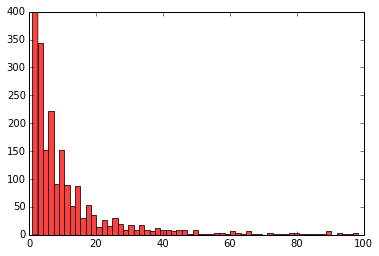

In [36]:
#histogram of the NN of reviews

# review number collection lost, dont erase the picture
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

n, bins, patches = plt.hist(reviewstats,len(reviewstats),  facecolor='r', alpha=0.75)
plt.axis([0, 100, 0, 400])

max_reviews = sorted(reviewstats, reverse=True)[0]
print "max number of reviews: ", max_reviews


In [38]:
# find several well-reviewed books
# WATCH PARAMETERS

i_max = 5
min_reviews = 20
sane_title_words = 'mechanics hamiltonian lagrangian mathematical'
high_score_treshold = 4.

i0 = 0
bigdfs = []
titles=[]

asinsSet = set([])

for asin in dfr.asin:
    if (asin in asinsSet): continue
    asinsSet.add(asin)
    
    dftry= dfr[np.logical_and(dfr.asin == asin, dfr.overall_score >= high_score_treshold)]
    #df1= dfr[dfr.asin == asin]
    
    #dftry=df1[dfr.overall_score >= high_score_treshold]
    nreviews = dftry.shape[0]
    
    if (nreviews > min_reviews) and (is_textbook_title(asin,sane_title_words,dfm)):
        i0 +=1
        bigdfs.append(dftry)
        titles.append(get_title(asin,dfm))
        
    if i0 >= i_max: break

In [6]:
bigdfs[1].shape

(25, 7)

<b>
For each title, draw distribution of stats:
</b>


 book: A Beginners Guide to Constructing the Universe: Mathematical Archetypes of Nature, Art, and Science
   asin: 0060926716
77 reviews
failed scores:
     automated_readability 1 failed
     flesch_kincaid 1 failed
     gunning_fog 4 failed
MEANS:
automated_readability 10.325
flesch_kincaid: 8.92631578947


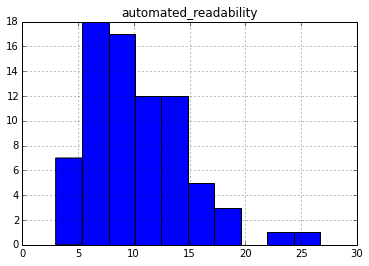

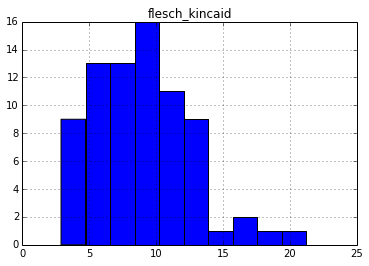


 book: An Introduction To Mechanics
   asin: 0070350485
25 reviews
failed scores:
     automated_readability 0 failed
     flesch_kincaid 0 failed
     gunning_fog 1 failed
MEANS:
automated_readability 10.92
flesch_kincaid: 9.228


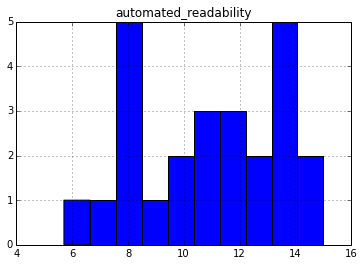

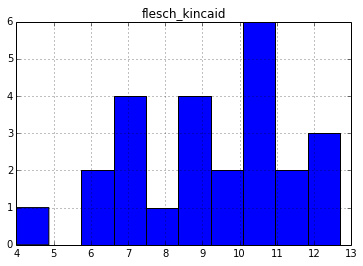


 book: Real and Complex Analysis (International Series in Pure and Applied Mathematics)
   asin: 0070542341
22 reviews
failed scores:
     automated_readability 0 failed
     flesch_kincaid 0 failed
     gunning_fog 2 failed
MEANS:
automated_readability 11.2409090909
flesch_kincaid: 9.88181818182


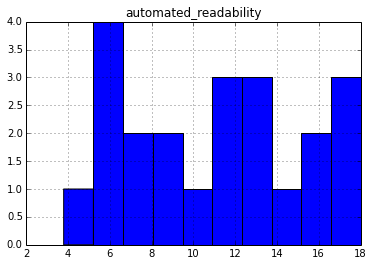

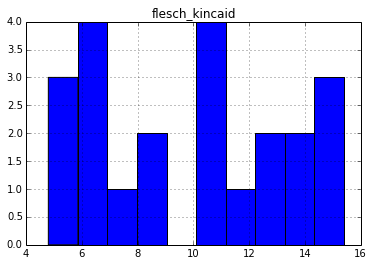


 book: Principles of Mathematical Analysis (International Series in Pure and Applied Mathematics)
   asin: 007054235X
80 reviews
failed scores:
     automated_readability 0 failed
     flesch_kincaid 0 failed
     gunning_fog 2 failed
MEANS:
automated_readability 10.89125
flesch_kincaid: 9.45375


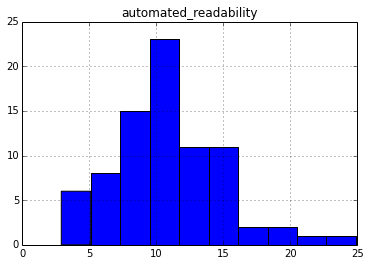

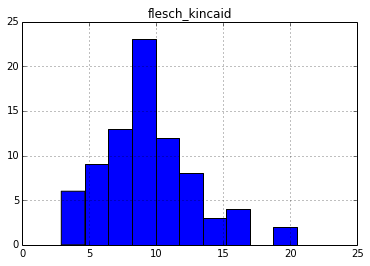


 book: Boatowners Mechanical and Electrical Manual: How to Maintain, Repair, and Improve Your Boats Essential Systems
   asin: 0071432388
101 reviews
failed scores:
     automated_readability 0 failed
     flesch_kincaid 0 failed
     gunning_fog 5 failed
MEANS:
automated_readability 8.31386138614
flesch_kincaid: 7.28613861386


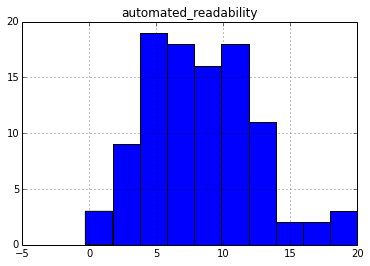

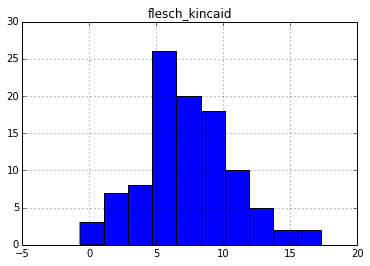

In [40]:
# FEW INDIVIDUAL PLOTS

plots = []
for i in range(len(titles)):
    book = bigdfs[i]
    title = titles[i]
    revs = book.review_text

    flesch_kincaid_grades = []
    automated_readability_indexes = []
    gunning_fogs = []

    failed_count = {'flesch_kincaid':0,
                    'automated_readability':0,
                    'gunning_fog': 0 }

    for rev in revs: 
        try:
            automated_readability_indexes.append(textstat.automated_readability_index(rev))
        except: 
            failed_count['automated_readability'] +=1

        try:
            flesch_kincaid_grades.append(textstat.flesch_kincaid_grade(rev))
        except: 
            failed_count['flesch_kincaid'] +=1

        try:
            gunning_fogs.append(textstat.gunning_fog(rev))
        except: 
            failed_count['gunning_fog'] +=1

    d1 = {'automated_readability': automated_readability_indexes}
    d2 = {'flesch_kincaid': flesch_kincaid_grades}
    d3 = {'gunning_fog' :  gunning_fogs}


    df1 = pd.DataFrame(d1)
    df2 = pd.DataFrame(d2)
    df3 = pd.DataFrame(d3)
    n_reviews = book.shape[0]


    print 
    print " book:" , title
    print "   asin:", book.asin.unique()[0]
    print  n_reviews, "reviews"
    print "failed scores:"
    for key in failed_count:
        print "    ", key, failed_count[key], "failed"
        
    print "MEANS:"
    print  'automated_readability',   df1.describe().automated_readability['mean']
    print 'flesch_kincaid:', df2.describe().flesch_kincaid['mean']

    # ------------------------------ PLOT HERE ----------------------
    plt.figure(1)
    p1 = df1.hist()
    p2 = df2.hist()
    #p3 = df3.hist()
    plt.show()
    plots.append([p1,p2])

In [7]:
# MANY POINTS

plots = []

dif_FK = []
dif_AR = []
dif_gunning = []
rev_ns = []

for i in range(len(titles)):
    book = bigdfs[i]
    title = titles[i]
    revs = book.review_text

    flesch_kincaid_grades = []
    automated_readability_indexes = []
    gunning_fogs = []

    failed_count = {'flesch_kincaid':0,
                    'automated_readability':0,
                    'gunning_fog': 0 }

    for rev in revs: 
        try:
            automated_readability_indexes.append(textstat.automated_readability_index(rev))
        except: 
            failed_count['automated_readability'] +=1

        try:
            flesch_kincaid_grades.append(textstat.flesch_kincaid_grade(rev))
        except: 
            failed_count['flesch_kincaid'] +=1

        try:
            gunning_fogs.append(textstat.gunning_fog(rev))
        except: 
            failed_count['gunning_fog'] +=1

    d1 = {'automated_readability': automated_readability_indexes}
    d2 = {'flesch_kincaid': flesch_kincaid_grades}
    d3 = {'gunning_fog' :  gunning_fogs}

    df1 = pd.DataFrame(d1)
    df2 = pd.DataFrame(d2)
    df3 = pd.DataFrame(d3)
    n_reviews = book.shape[0]
    
    dif_AR.append(df1.describe().automated_readability['mean'])
    dif_FK.append(df2.describe().flesch_kincaid['mean'])
    dif_gunning.append(df3.describe().gunning_fog['mean'])
    rev_ns.append(n_reviews)

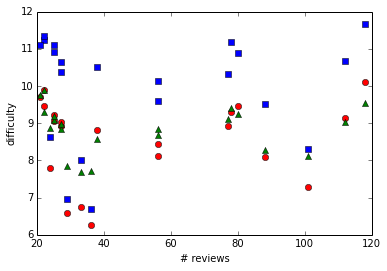

In [8]:

plt.plot(rev_ns,dif_FK,'ro', # red circle
         rev_ns,dif_AR,'bs', # blue square
         rev_ns,dif_gunning,'g^', # green triangle
        )

plt.ylabel('difficulty')
plt.xlabel('# reviews')

plt.show()
# plt.plot(rev_ns,dif_FK,'ro', # red circle
#          rev_ns,dif_AR,'bs', # blue square
#          rev_ns,dif_gunning,'g^', # green triangle
#         )
# plt.axis([0, 500, 0, 15])
# plt.ylabel('difficulty')
# plt.xlabel('# reviews')

In [ ]:
plt.figure(1)
plt.subplot(311)
book0df['automated_readability'].hist()

plt.subplot(312)
book0df['flesch_kincaid'].hist()

plt.subplot(313)
book0df['gunning_fog'].hist()

In [ ]:
af_m

In [ ]:
def get_title(asin,dfm):
    return dfm[dfm.asin==asin].title.values[0]

def is_textbook_title(asin,sane_title_words,dfm):
    return filtered_cosine_similarity(sane_title_words_string,title) > 0

get_title('006223059X',dfm)

In [ ]:
keywdict /= book.shape[0]

<h2>
<font color = 'red'>
TRYING TF-IDF  WITH TITLES
</font>
</h2>

In [53]:
titles

['A Beginners Guide to Constructing the Universe: Mathematical Archetypes of Nature, Art, and Science',
 'An Introduction To Mechanics',
 'Real and Complex Analysis (International Series in Pure and Applied Mathematics)',
 'Principles of Mathematical Analysis (International Series in Pure and Applied Mathematics)',
 'Boatowners Mechanical and Electrical Manual: How to Maintain, Repair, and Improve Your Boats Essential Systems',
 'Making Things Move DIY Mechanisms for Inventors, Hobbyists, and Artists',
 'The Gamification Revolution: How Leaders Leverage Game Mechanics to Crush the Competition',
 'Shigleys Mechanical Engineering Design (McGraw-Hill Series in Mechanical Engineering)',
 'Introduction to Quantum Mechanics (2nd Edition)',
 'Introduction to Quantum Mechanics',
 'Advanced Engineering Mathematics (2nd Edition)',
 'Engineering Mechanics: Statics (12th Edition)',
 'Journey through Genius: The Great Theorems of Mathematics',
 'What Is Mathematics? An Elementary Approach to Ideas 

In [4]:
#---- http://stevenloria.com/finding-important-words-in-a-document-using-tf-idf/ ---

import math
from textblob import TextBlob as tb

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

<h2>
<font color = 'green'>
RESULTS:  difficulty scores, and review length vs difficulty <br>
for books on mechanics <br>
50 reviews and up
</font>
</h2>

In [ ]:
My own subjective scores:

book: A Beginners Guide to Constructing the Universe: Mathematical Archetypes of Nature, Art, and Science
   asin: 0060926716
    --------------- high school to ndergrad; not textbook ---------------
    
 book: Principles of Mathematical Analysis (International Series in Pure and Applied Mathematics)
   asin: 007054235X
    ---------------- advanced undergrad to grad -----------
    
 book: Introduction to Quantum Mechanics (2nd Edition)
   asin: 0131118927

    ------------------ undergrad, 1st course  ---------------
    
 book: Principles of Quantum Mechanics, 2nd Edition
   asin: 0306447908
    ----------------- advanced undergrad to grad  -----------------

 book: Our Mathematical Universe: My Quest for the Ultimate Nature of Reality
   asin: 0307599809
    --------------------- advanced popular science -------------
    

In [ ]:
# FEW INDIVIDUAL PLOTS


<h2>
<font color = 'green'>
RESULTS:  difficulty scores, and review length vs difficulty <br>
for books on mechanics <br>
15 reviews and up
</font>
</h2>

In [ ]:
My own subjective scores:

A Beginners Guide to Constructing the Universe: Mathematical Archetypes of Nature, Art, and Science
   asin: 0060926716  
    --------------- undergrad and below -- popular math ---------------
    
book: An Introduction To Mechanics
   asin: 0070350485
    ---------------- undergrad @ MIT -- but style is strict -----------
    
 book: Schaums Outline of Quantum Mechanics (Schaums)
   asin: 0070540187
    ------------------undergrad, 3-rd year or so ---------------
    
 book: Principles of Mathematical Analysis (International Series in Pure and Applied Mathematics)
asin: 007054235X
    ----------------- undergrad to early grad -----------------

book: Schaums Outline of Lagrangian Dynamics
   asin: 0070692580
    --------------------- undergrad -------------
    

In [ ]:
individual scores

In [ ]:
3 scores vs

<h2>
<font color = 'green'>
RESULTS:  difficulty scores, and review length vs difficulty for general books
</font>
</h2>

In [ ]:
#histogram of the NN of reviews

<h2>
<font color = 'PURPLE'>
SPECIAL WORDS
</font>
</h2>

In [91]:
adv_words = ['advanced',
             'professors',
             'Lagrangian',
             'Hamiltonian',
             'graduate'
            ]

intro_words = ['introductory',
               'introduction',
              'freshman',
              'undergraduate',
               'elementary',
               'first',
               'beginner'
              ]

In [92]:
def stem_words(words):
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in words:
        stemmed.append(stemmer.stem(item))
    return stemmed

def get_stemmed_set(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    filtered = get_filtered_counter(text)
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))
    return set(stemmed)


adv_w = stem_words(adv_words)
intro_w = stem_words(intro_words)


keywords = adv_w + intro_w 
keywords

keywdict = {}
for keyword in keywords:
    keywdict[keyword] = 0.

keywdict

{u'Hamiltonian': 0.0,
 u'Lagrangian': 0.0,
 u'advanc': 0.0,
 u'beginn': 0.0,
 u'elementari': 0.0,
 u'first': 0.0,
 u'freshman': 0.0,
 u'graduat': 0.0,
 u'introduct': 0.0,
 u'introductori': 0.0,
 u'professor': 0.0,
 u'undergradu': 0.0}


 book: A Beginners Guide to Constructing the Universe: Mathematical Archetypes of Nature, Art, and Science
   asin: 0060926716
77 reviews
validation: undergrad and below -- popular math


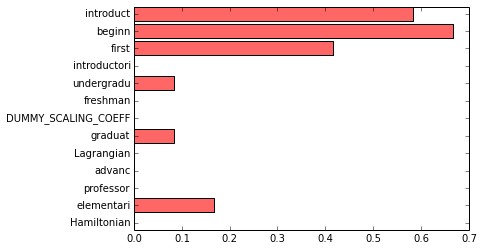


 book: An Introduction To Mechanics
   asin: 0070350485
25 reviews
validation: undergrad @ MIT -- but style is strict


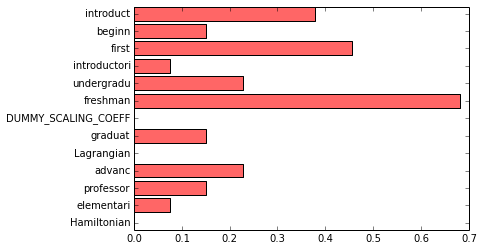


 book: Real and Complex Analysis (International Series in Pure and Applied Mathematics)
   asin: 0070542341
22 reviews
validation:

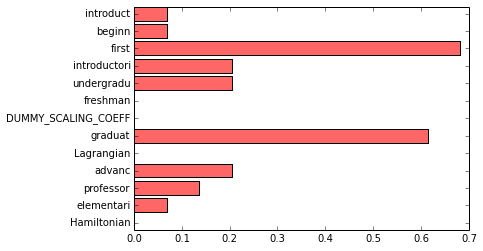


 book: Principles of Mathematical Analysis (International Series in Pure and Applied Mathematics)
   asin: 007054235X
80 reviews
validation: undergrad to early grad


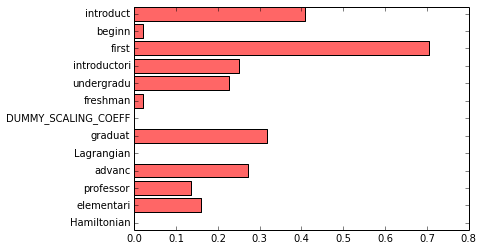


 book: Boatowners Mechanical and Electrical Manual: How to Maintain, Repair, and Improve Your Boats Essential Systems
   asin: 0071432388
101 reviews
validation:

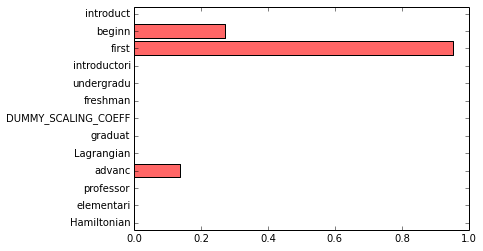


 book: Making Things Move DIY Mechanisms for Inventors, Hobbyists, and Artists
   asin: 0071741674
56 reviews
validation:

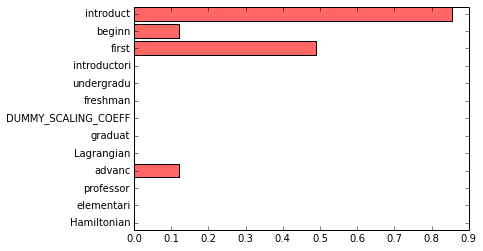


 book: The Gamification Revolution: How Leaders Leverage Game Mechanics to Crush the Competition
   asin: 0071808310
24 reviews
validation:

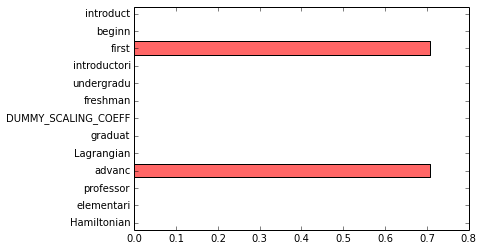

In [47]:
# ------------------------------ KEYWORDS IN REVIEWS ------------------------------
import math

def normalize_dict_1(keywdict):
    for key in keywdict:
        keywdict[key] /= book.shape[0]
    return keydict

def normalize_dict_2(keywdict):
    
    norm = 0.
    for key in keywdict:
        keywdict[key] += 1.e-100
        norm += keywdict[key]*keywdict[key]
    for key in keywdict:
        keywdict[key] /= math.sqrt(norm)
        
    return keywdict
    
for i in range(len(titles)):
    book = bigdfs[i]
    title = titles[i]
    revs = book.review_text.values
    n_reviews = book.shape[0]

    for keyword in keywords:
        keywdict[keyword] = 0.
    
    for rev in revs:
        stemmed_rev = get_stemmed_set(rev)
        for word in stemmed_rev:
            if word in keywdict:
                keywdict[word]+=1.

    keydict = normalize_dict_2(keywdict)
    
    print 
    print " book:" , title
    print "   asin:", book.asin.unique()[0]
    print  n_reviews, "reviews"
    try:
        print 'validation:', validation[title]
    except: pass

    plt.yticks(range(len(keywdict)), keywdict.keys())
    plt.barh(range(len(keywdict)), keywdict.values(),align='center',color='#FF6666')
    plt.show()
    
    if i>5: break

    
# dfplot = pd.DataFrame(keywdict,index=[0])
# plot = dfplot.plot(kind='barh',rot=10)



 book: A Beginners Guide to Constructing the Universe: Mathematical Archetypes of Nature, Art, and Science
   asin: 0060926716
77 reviews
validation: undergrad and below -- popular math


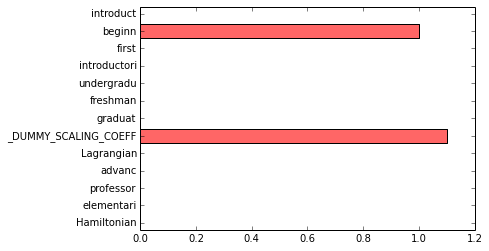


 book: An Introduction To Mechanics
   asin: 0070350485
25 reviews
validation: undergrad @ MIT -- but style is strict


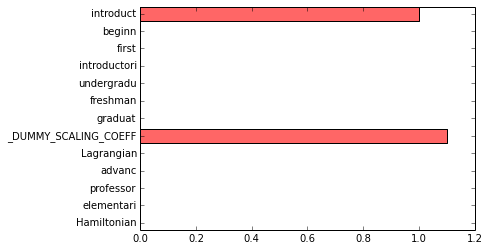


 book: Real and Complex Analysis (International Series in Pure and Applied Mathematics)
   asin: 0070542341
22 reviews
validation:

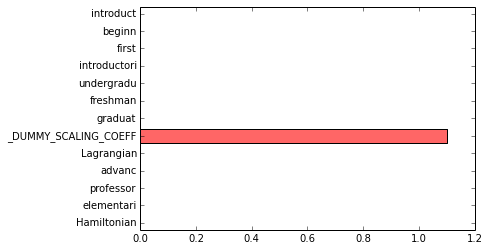


 book: Principles of Mathematical Analysis (International Series in Pure and Applied Mathematics)
   asin: 007054235X
80 reviews
validation: undergrad to early grad


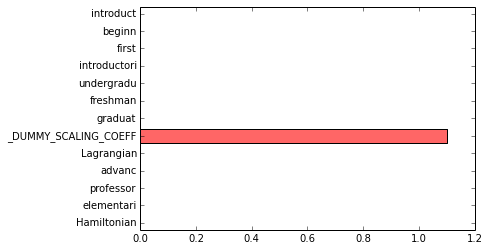


 book: Boatowners Mechanical and Electrical Manual: How to Maintain, Repair, and Improve Your Boats Essential Systems
   asin: 0071432388
101 reviews
validation:

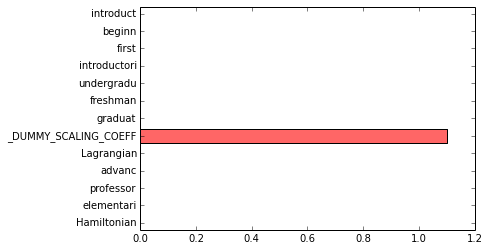


 book: Making Things Move DIY Mechanisms for Inventors, Hobbyists, and Artists
   asin: 0071741674
56 reviews
validation:

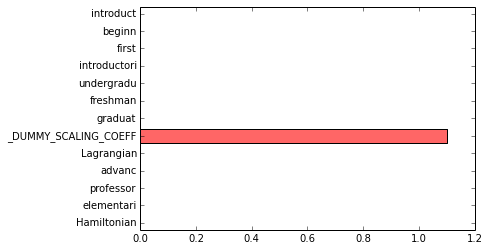


 book: The Gamification Revolution: How Leaders Leverage Game Mechanics to Crush the Competition
   asin: 0071808310
24 reviews
validation:

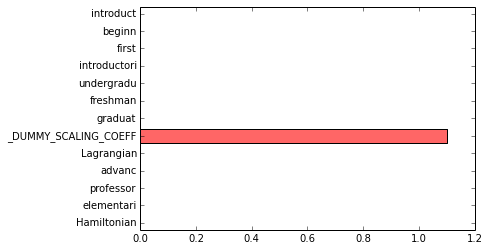


 book: Shigleys Mechanical Engineering Design (McGraw-Hill Series in Mechanical Engineering)
   asin: 0073529281
29 reviews
validation:

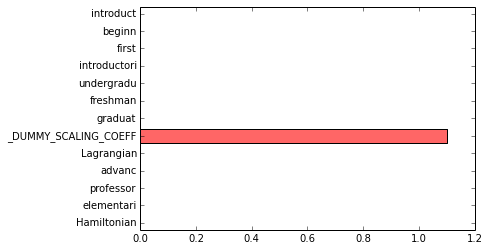


 book: Introduction to Quantum Mechanics (2nd Edition)
   asin: 0131118927
88 reviews
validation: undergrad, 1st course


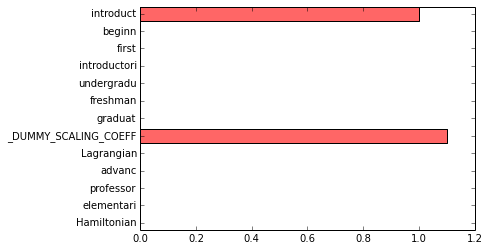


 book: Introduction to Quantum Mechanics
   asin: 0131244051
25 reviews
validation:

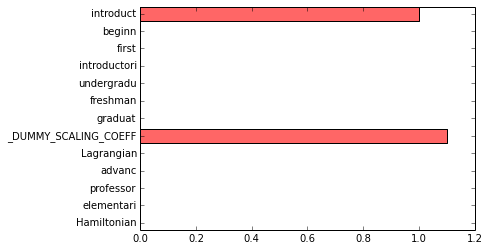


 book: Advanced Engineering Mathematics (2nd Edition)
   asin: 0133214311
27 reviews
validation:

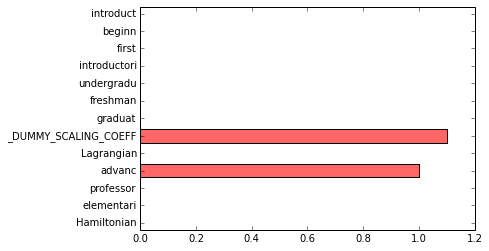


 book: Engineering Mechanics: Statics (12th Edition)
   asin: 0136077900
36 reviews
validation:

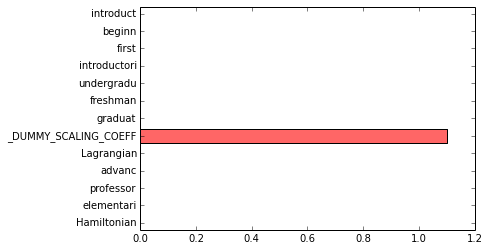


 book: Journey through Genius: The Great Theorems of Mathematics
   asin: 014014739X
112 reviews
validation:

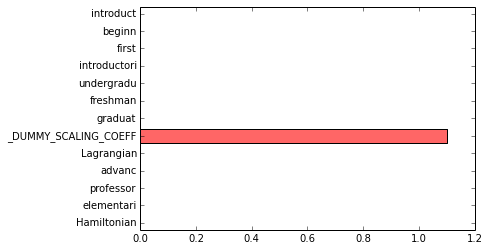


 book: What Is Mathematics? An Elementary Approach to Ideas and Methods
   asin: 0195105192
38 reviews
validation:

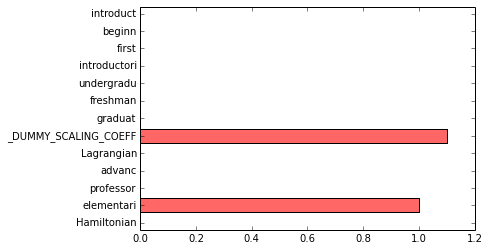


 book: Modern Quantum Mechanics (Revised Edition)
   asin: 0201539292
27 reviews
validation:

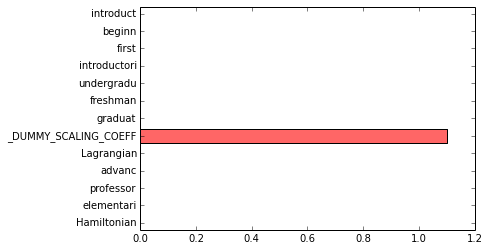


 book: Elementary and Middle School Mathematics: Teaching Developmentally (7th Edition)
   asin: 0205573525
33 reviews
validation:

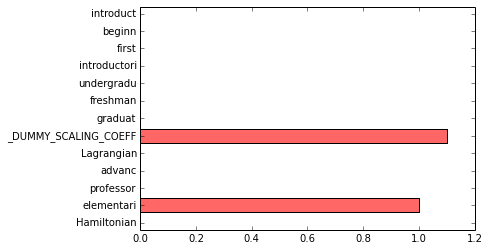


 book: Holistic Game Development with Unity: An All-in-One Guide to Implementing Game Mechanics, Art, Design and Programming
   asin: 0240819330
21 reviews
validation:

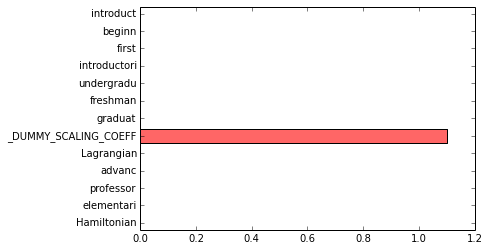


 book: The Outer Limits of Reason: What Science, Mathematics, and Logic Cannot Tell Us
   asin: 0262019353
22 reviews
validation:

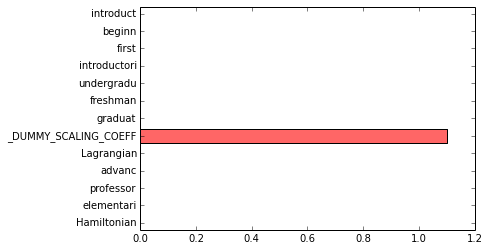


 book: Principles of Quantum Mechanics, 2nd Edition
   asin: 0306447908
56 reviews
validation: advanced undergrad to grad


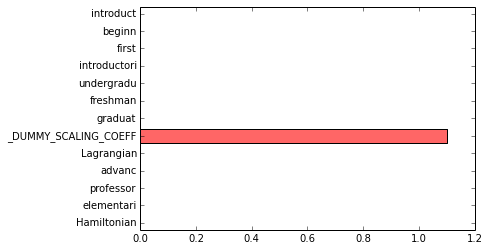


 book: Our Mathematical Universe: My Quest for the Ultimate Nature of Reality
   asin: 0307599809
118 reviews
validation: advanced popular science


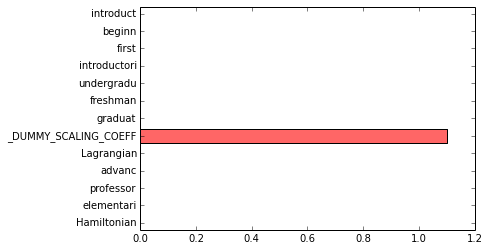


 book: The Black Hole War: My Battle with Stephen Hawking to Make the World Safe for Quantum Mechanics
   asin: 0316016403
78 reviews
validation:

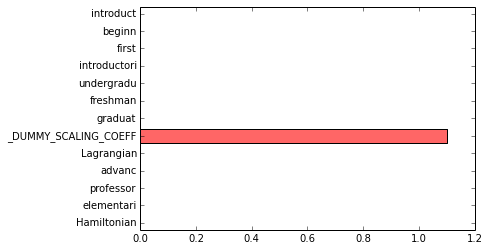

In [51]:
# ------------------------------ KEYWORDS IN TITLES -------------------
import math

def normalize_dict_1(keywdict):
    for key in keywdict:
        keywdict[key] /= book.shape[0]
    return keydict

def normalize_dict_2(keywdict):
    norm = 0.
    for key in keywdict:
        keywdict[key] += 1.e-100
        norm += keywdict[key]*keywdict[key]
    for key in keywdict:
        keywdict[key] /= math.sqrt(norm)
        
    return keywdict
    
for i in range(len(titles)):
    book = bigdfs[i]
    title = titles[i]
    n_reviews = book.shape[0]

    for keyword in keywords:
        keywdict[keyword] = 0.001
    keywdict['_DUMMY_SCALING_COEFF'] = 1.1
    
    stemmed_title = get_stemmed_set(title)
    for word in stemmed_title:
        if word in keywdict:
            keywdict[word]+=1.

    #keydict = normalize_dict_2(keywdict)
    
    print 
    print " book:" , title
    print "   asin:", book.asin.unique()[0]
    print  n_reviews, "reviews"
    try:
        print 'validation:', validation[title]
    except: pass

    plt.yticks(range(len(keywdict)), keywdict.keys())
    plt.barh(range(len(keywdict)), keywdict.values(),align='center',color='#FF6666')
    plt.show()
    
    if i>25: break

    
# dfplot = pd.DataFrame(keywdict,index=[0])
# plot = dfplot.plot(kind='barh',rot=10)


A Beginners Guide to Constructing the Universe: Mathematical Archetypes of Nature, Art, and Science
set([u'a', u'and', u'art', u'natur', u'univers', u'construct', u'to', u'mathemat', u'of', u'archetyp', u'the', u'guid', u'beginn', u'scienc'])


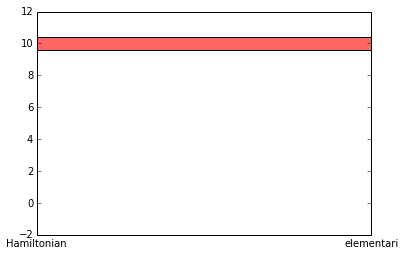

In [43]:
title = titles[0]

stemmed_title = get_stemmed_set(title)

print title

print stemmed_title

keywdict = {}
for keyword in keywords:
    keywdict[keyword] = 0.001

for word in stemmed_title:
    if word in keywdict:
        keywdict[word]+=1.

plt.xticks(range(len(keywdict)), keywdict.keys())
plt.barh(range(len(keywdict)), keywdict.values(),align='center',color='#FF6666')
plt.show()



In [24]:
keywords

[u'advanc',
 u'professor',
 u'Lagrangian',
 u'Hamiltonian',
 u'graduat',
 u'introductori',
 u'introduct',
 u'freshman',
 u'undergradu',
 u'elementari',
 u'first',
 u'beginn']

<h2>
<font color = 'PURPLE'>
Filtered by >20 positive reviews, only positive count
</font>
</h2>

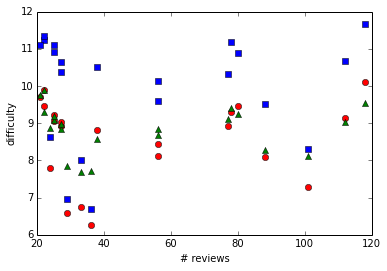

In [8]:

plt.plot(rev_ns,dif_FK,'ro', # red circle
         rev_ns,dif_AR,'bs', # blue square
         rev_ns,dif_gunning,'g^', # green triangle
        )



 book: A Beginners Guide to Constructing the Universe: Mathematical Archetypes of Nature, Art, and Science
   asin: 0060926716
77 reviews
failed scores:
     automated_readability 1 failed
     flesch_kincaid 1 failed
     gunning_fog 4 failed
MEANS:
automated_readability 10.325
flesch_kincaid: 8.92631578947

 book: An Introduction To Mechanics
   asin: 0070350485
25 reviews
failed scores:
     automated_readability 0 failed
     flesch_kincaid 0 failed
     gunning_fog 1 failed
MEANS:
automated_readability 10.92
flesch_kincaid: 9.228

 book: Real and Complex Analysis (International Series in Pure and Applied Mathematics)
   asin: 0070542341
22 reviews
failed scores:
     automated_readability 0 failed
     flesch_kincaid 0 failed
     gunning_fog 2 failed
MEANS:
automated_readability 11.2409090909
flesch_kincaid: 9.88181818182

 book: Principles of Mathematical Analysis (International Series in Pure and Applied Mathematics)
   asin: 007054235X
80 reviews
failed scores:
     automated


 book: A Beginners Guide to Constructing the Universe: Mathematical Archetypes of Nature, Art, and Science
   asin: 0060926716
77 reviews
validation: undergrad and below -- popular math


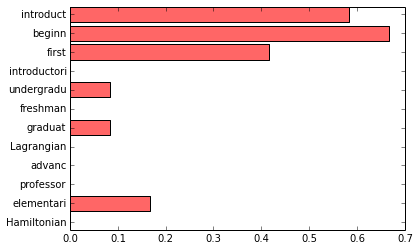


 book: An Introduction To Mechanics
   asin: 0070350485
25 reviews
validation: undergrad @ MIT -- but style is strict


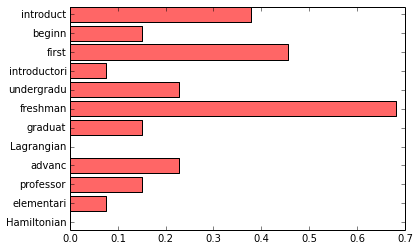


 book: Real and Complex Analysis (International Series in Pure and Applied Mathematics)
   asin: 0070542341
22 reviews
validation:

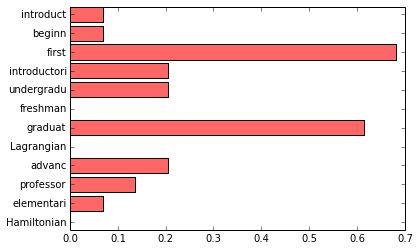


 book: Principles of Mathematical Analysis (International Series in Pure and Applied Mathematics)
   asin: 007054235X
80 reviews
validation: undergrad to early grad


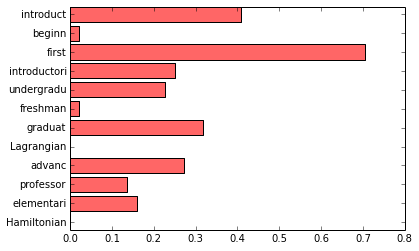


 book: Boatowners Mechanical and Electrical Manual: How to Maintain, Repair, and Improve Your Boats Essential Systems
   asin: 0071432388
101 reviews
validation:

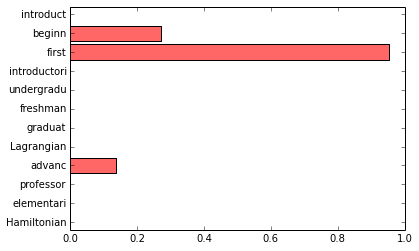


 book: Making Things Move DIY Mechanisms for Inventors, Hobbyists, and Artists
   asin: 0071741674
56 reviews
validation:

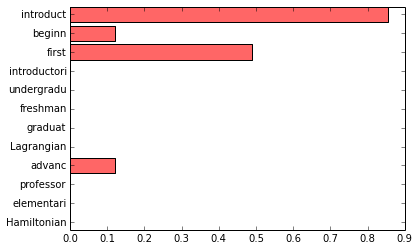


 book: The Gamification Revolution: How Leaders Leverage Game Mechanics to Crush the Competition
   asin: 0071808310
24 reviews
validation:

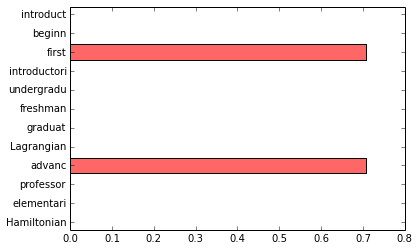

In [12]:
# ------------------------ KEYWORDS IN REVIEWS ---------------------------



 book: A Beginners Guide to Constructing the Universe: Mathematical Archetypes of Nature, Art, and Science
   asin: 0060926716
77 reviews
validation: undergrad and below -- popular math


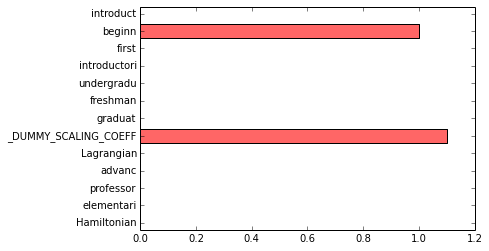


 book: An Introduction To Mechanics
   asin: 0070350485
25 reviews
validation: undergrad @ MIT -- but style is strict


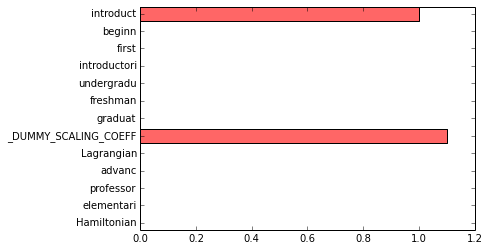


 book: Real and Complex Analysis (International Series in Pure and Applied Mathematics)
   asin: 0070542341
22 reviews
validation:

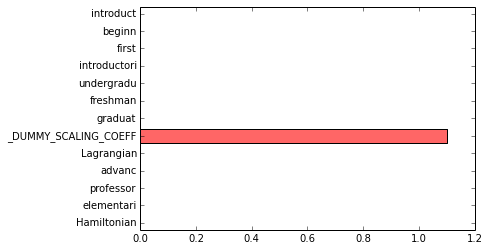


 book: Principles of Mathematical Analysis (International Series in Pure and Applied Mathematics)
   asin: 007054235X
80 reviews
validation: undergrad to early grad


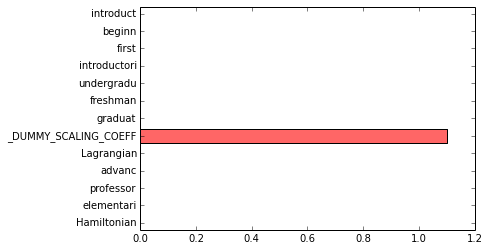


 book: Boatowners Mechanical and Electrical Manual: How to Maintain, Repair, and Improve Your Boats Essential Systems
   asin: 0071432388
101 reviews
validation:

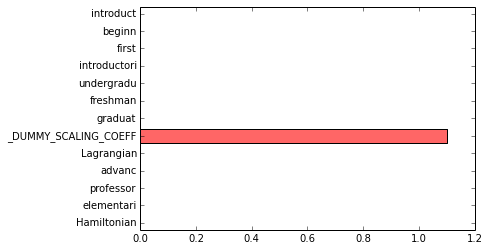


 book: Making Things Move DIY Mechanisms for Inventors, Hobbyists, and Artists
   asin: 0071741674
56 reviews
validation:

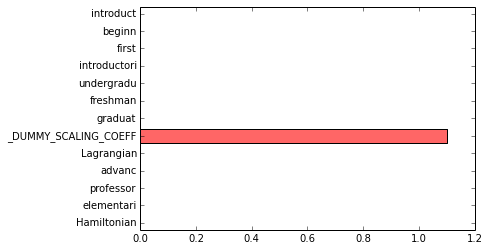


 book: The Gamification Revolution: How Leaders Leverage Game Mechanics to Crush the Competition
   asin: 0071808310
24 reviews
validation:

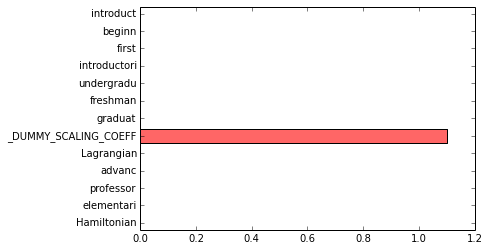


 book: Shigleys Mechanical Engineering Design (McGraw-Hill Series in Mechanical Engineering)
   asin: 0073529281
29 reviews
validation:

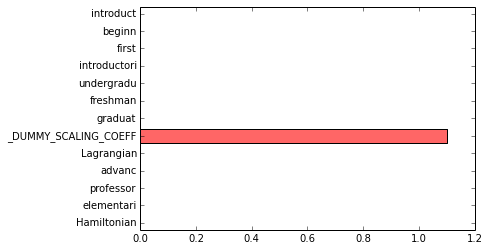


 book: Introduction to Quantum Mechanics (2nd Edition)
   asin: 0131118927
88 reviews
validation: undergrad, 1st course


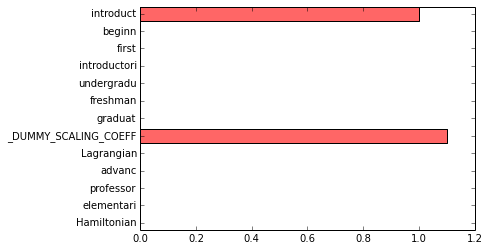


 book: Introduction to Quantum Mechanics
   asin: 0131244051
25 reviews
validation:

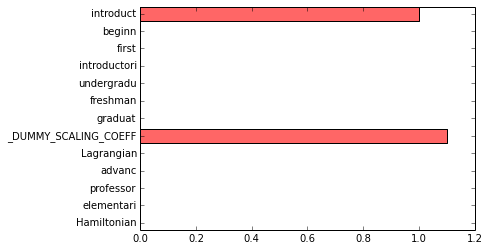


 book: Advanced Engineering Mathematics (2nd Edition)
   asin: 0133214311
27 reviews
validation:

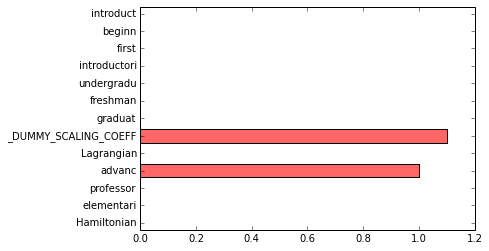


 book: Engineering Mechanics: Statics (12th Edition)
   asin: 0136077900
36 reviews
validation:

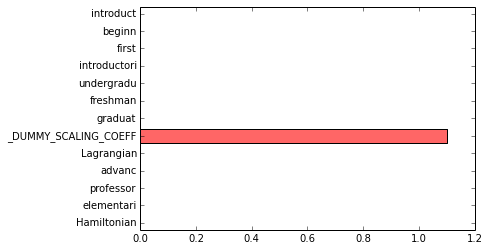


 book: Journey through Genius: The Great Theorems of Mathematics
   asin: 014014739X
112 reviews
validation:

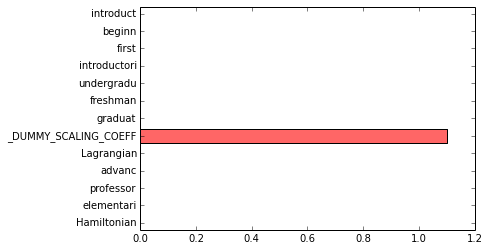


 book: What Is Mathematics? An Elementary Approach to Ideas and Methods
   asin: 0195105192
38 reviews
validation:

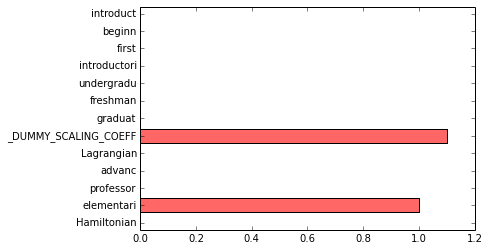


 book: Modern Quantum Mechanics (Revised Edition)
   asin: 0201539292
27 reviews
validation:

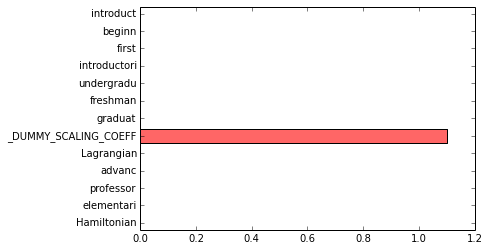


 book: Elementary and Middle School Mathematics: Teaching Developmentally (7th Edition)
   asin: 0205573525
33 reviews
validation:

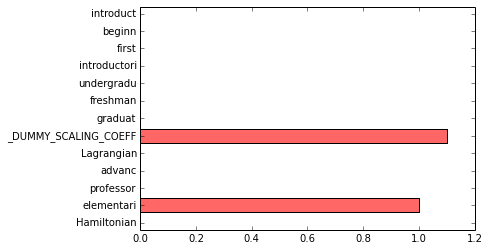


 book: Holistic Game Development with Unity: An All-in-One Guide to Implementing Game Mechanics, Art, Design and Programming
   asin: 0240819330
21 reviews
validation:

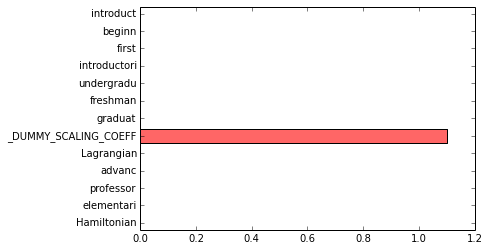


 book: The Outer Limits of Reason: What Science, Mathematics, and Logic Cannot Tell Us
   asin: 0262019353
22 reviews
validation:

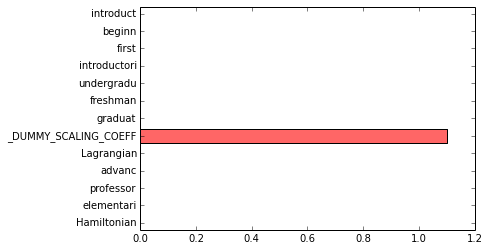


 book: Principles of Quantum Mechanics, 2nd Edition
   asin: 0306447908
56 reviews
validation: advanced undergrad to grad


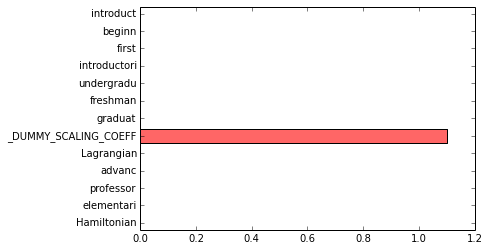


 book: Our Mathematical Universe: My Quest for the Ultimate Nature of Reality
   asin: 0307599809
118 reviews
validation: advanced popular science


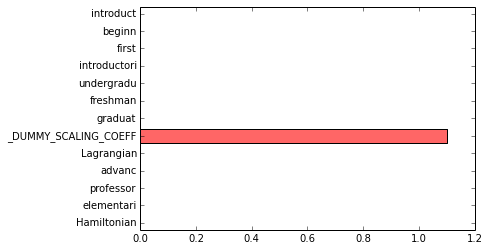


 book: The Black Hole War: My Battle with Stephen Hawking to Make the World Safe for Quantum Mechanics
   asin: 0316016403
78 reviews
validation:

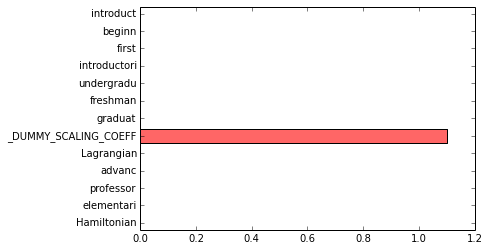

In [51]:
# ------------------------------ KEYWORDS IN TITLES -------------------


<h3>
Create file for testing set
</h3>

In [1]:
i = 0
amazon_base = 'http://www.amazon.com/dp/'
asinset=set([])
sane_title_words = 'mechanics hamiltonian lagrangian mathematical'

with open('trainingSet.csv','w') as f:
    f.write('amazon ID, title, url, , advanced (2)/ introductory (1)/ not science textbook (0), \n')
    f.write('\n')
    
    for title in dfm.title:
        asin = dfm[dfm.title==title].asin.values[0]
        url = amazon_base+asin
        asinset.add(asin)
        
        dftry= dfr[np.logical_and(dfr.asin == asin, dfr.overall_score >= 4)]
        nreviews = dftry.shape[0]
        if (nreviews < 15): continue
        #if (not is_textbook_title(asin,sane_title_words,dfm)): continue
        #if asin in asinset: continue
        
        f.write(asin)
        f.write(',')
        f.write(title)
        f.write(',')
        f.write(url)
        f.write('\n')
        
        i+=1
        if i > 10: break

NameError: name 'dfm' is not defined

In [18]:
 dfm[dfm.title==title].asin.values[0]

'0023547618'

<h1>
<font color = 'red'>
  LEARNING TO LEARN
<font>
</h2>

In [41]:
# ---- set 1 - 3 classes, set 2 - 2 classes -----------------
training = pd.DataFrame.from_csv('training_set_2.csv')
training = training.reset_index()
high_score_treshold = 4.

training['nrevs'] = 0.
training['ar_score'] = 0.
training['fk_score'] = 0.
# training.drop('index', axis=1, inplacetraining.drop('index', axis=1, inplace=True)
# training.drop('level_0', axis=1, inplace=True)

# ----------FILL  THE TRAINING WEIGHTS --------
for index, row in training.iterrows():
    
    asin = row.asin
    df = dfr[dfr.asin==asin]
    nrevs = df.shape[0]
    revs = df[df.overall_score >= high_score_treshold].review_text
    
    score01 = 0.
    score02 = 0.
    scores1_count = 0
    scores2_count = 0
    debug_failed_count = 0
    
    for rev in revs: 
        try:
            #a number that approximates the grade level needed to comprehend the text.
            score1 = textstat.automated_readability_index(rev)
            score01 += score1
            scores1_count +=1
        except: debug_failed_count +=1
            
        try: 
            #flesch_reading_ease  https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
            score2 = textstat.flesch_kincaid_grade(rev)
            score02 += score2
            scores2_count +=1
        except: debug_failed_count +=1
            
    if scores1_count > 0:
        score01 /= scores1_count
        
    if scores2_count > 0:
        score02 /= scores2_count
        
    indx = training[training.asin == asin].index
    training.loc[indx,'ar_score'] = score01
    training.loc[indx,'fk_score'] = score02
    training.loc[indx,'nrevs'] = nrevs 
    

training=training.sort('score')
training


,asin,score,nrevs,ar_score,fk_score
20,0199225869,1,35,10.150000,8.533333
32,0201380277,1,61,10.864103,9.038462
28,0201021153,1,78,10.523611,9.027778
27,0199918112,1,38,11.561290,10.035484
26,0199919755,1,149,13.047000,11.105000
25,0199603499,1,37,11.888889,10.100000
24,0199572194,1,32,10.713333,9.206667
23,0199291152,1,291,10.273577,8.991463
22,0199232369,1,26,12.761905,10.780952
21,0199236224,1,17,10.856250,9.875000


In [101]:
# -------------- pickle training set ----------------
training.to_pickle('trainingBooks.pkl')
tr2 = pd.read_pickle('trainingBooks.pkl')

In [243]:
# ---------  logistic regression -------------------
from sklearn import linear_model, datasets


In [244]:
scores = training.score.values.tolist()
ARscores = training.ar_score.values.tolist()
FKscores = training.fk_score.values.tolist()

len(FKscores)

dummyScores= np.zeros((42,), dtype=np.float)


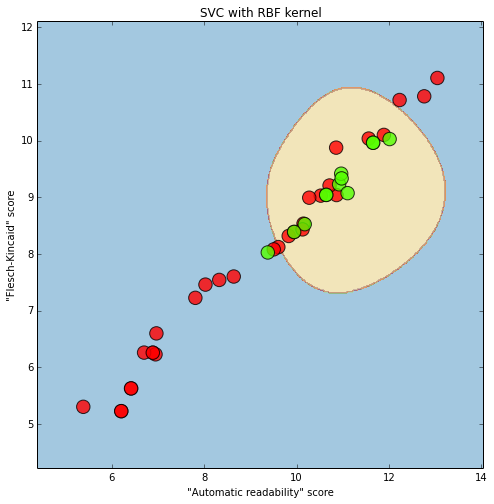

In [215]:
# -------------- USE THIS ONE ---------------

#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# # import some data to play with
# iris = datasets.load_iris()
# X = iris.data[:, :2]  # we only take the first two features. We could
#                       # avoid this ugly slicing by using a two-dim dataset
# y = iris.target

X = np.array([training.ar_score,training.fk_score]).T
y = np.array(training.score)

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1  # SVM regularization param'auto'
# svc = svm.SVC(kernel='linear', C=C).fit(X, y)
clf = svm.SVC(kernel='rbf', gamma=0.4, C=C, class_weight='auto').fit(X, y)
# poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
# lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
title = 'SVC with RBF kernel'

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].


Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.prism, alpha = 0.8, s=180)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('"Automatic readability" score')
plt.ylabel('"Flesch-Kincaid" score')
plt.title(title)
fig.set_size_inches(8,8)

plt.show()

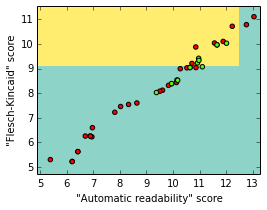

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

# http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#example-linear-model-plot-iris-logistic-py
#X = np.array([training.ar_score, dummyScores]).T
X = np.array([training.ar_score,training.fk_score]).T
Y = np.array(training.score)

# XX = np.array([ARscores,FKscores]).T
# YY = np.array(scores)
h = 0.4

logreg = linear_model.LogisticRegression(C=1.e15,class_weight='auto')

rf = RandomForestClassifier(n_estimators=1,class_weight='auto',max_depth=4)
# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, Y)
rf.fit(X, Y)

# http://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#example-linear-model-plot-iris-logistic-py

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
ZZ = rf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ZZ = ZZ.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
#plt.pcolormesh(xx, yy, ZZ, cmap=plt.cm.Set3)
plt.pcolormesh(xx, yy, ZZ, cmap=plt.cm.Set3)

# Plot also the training points
#plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.prism)
plt.xlabel('"Automatic readability" score')
plt.ylabel('"Flesch-Kincaid" score')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
# plt.xticks(())
# plt.yticks(())

plt.show()



In [202]:
logreg.predict([12,12])[0]

0

In [255]:
# ------------------  pickle -------------------------
from sklearn.externals import joblib

joblib.dump(clf, './classifyer/classifyer.pkl') 

lg2 = joblib.load('./classifyer/classifyer.pkl')

Z = lg2.predict([12,10])
Z[0]

#

2

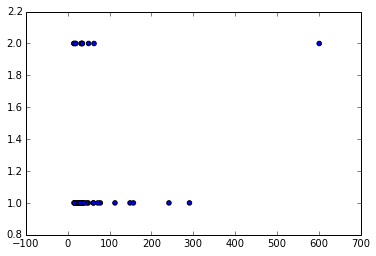

In [10]:
# ----------- new take on the review length ---- not really working ---------------------
%matplotlib inline
plt.scatter(training.nrevs, training.score, edgecolors='k', cmap=plt.cm.prism)
plt.show()

<h1>
<font color = 'red'>
LEARNING TO VALIDATE
</font>
</h1>

In [11]:
training

,asin,score,nrevs,ar_score,fk_score
20,0199225869,1,35,10.150000,8.533333
32,0201380277,1,61,10.864103,9.038462
28,0201021153,1,78,10.523611,9.027778
27,0199918112,1,38,11.561290,10.035484
26,0199919755,1,149,13.047000,11.105000
25,0199603499,1,37,11.888889,10.100000
24,0199572194,1,32,10.713333,9.206667
23,0199291152,1,291,10.273577,8.991463
22,0199232369,1,26,12.761905,10.780952
21,0199236224,1,17,10.856250,9.875000


In [33]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(clf, X, Y, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

scores

Accuracy: 0.68 (+/- 0.40)


array([ 0.4 ,  0.6 ,  0.5 ,  0.5 ,  0.75,  0.75,  0.75,  1.  ,  0.5 ,  1.  ])

<h1>
<font color = 'red'>
LEARNING TO USE TEXT FEATURES
</font>
</h1>

In [42]:
training

,asin,score,nrevs,ar_score,fk_score
20,0199225869,1,35,10.150000,8.533333
32,0201380277,1,61,10.864103,9.038462
28,0201021153,1,78,10.523611,9.027778
27,0199918112,1,38,11.561290,10.035484
26,0199919755,1,149,13.047000,11.105000
25,0199603499,1,37,11.888889,10.100000
24,0199572194,1,32,10.713333,9.206667
23,0199291152,1,291,10.273577,8.991463
22,0199232369,1,26,12.761905,10.780952
21,0199236224,1,17,10.856250,9.875000


In [44]:
# ---------- add title to training -------
training.title = ''

In [51]:
for asin in training.asin:
    title = dfm.title[dfm.asin==asin].values
    indx = training[training.asin == asin].index
    training.loc[indx,'title'] = title

titles = training.title.values

titles2 = training[training.score==2].title.values

titles1 = training[training.score==1].title.values

titles2

array(['An Introduction To Quantum Field Theory (Frontiers in Physics)',
       'Modern Quantum Mechanics (Revised Edition)',
       'An Introduction To Mechanics', 'Visual Complex Analysis',
       'Cosmology',
       'The Principles of Quantum Mechanics (International Series of Monographs on Physics)',
       'Introduction to Quantum Mechanics',
       'Modern Quantum Mechanics (Revised Edition)',
       'The Feynman Lectures on Physics, Vol. 1: Mainly Mechanics, Radiation, and Heat',
       'The Principles of Quantum Mechanics (International Series of Monographs on Physics)',
       'The Feynman Lectures on Physics, Vol. 3',
       'The Road to Serfdom: Text and Documents--The Definitive Edition (The Collected Works of F. A. Hayek, Volume 2)'], dtype=object)

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

NameError: name 'twenty_train' is not defined

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0, stop_words = 'english')

In [65]:
tfidf_matrix2 =  tf.fit_transform(titles2)
dense2 = tfidf_matrix2.todense()

tfidf_matrix1 =  tf.fit_transform(titles1)
dense1 = tfidf_matrix1.todense()

tfidf_matrix_all =  tf.fit_transform(titles)
dense_all = tfidf_matrix1.todense()



In [66]:
dense_all

matrix([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.3011896,
          0.3011896],
        ..., 
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ]])

In [68]:
#http://stevenloria.com/finding-important-words-in-a-document-using-tf-idf/

import math
from textblob import TextBlob as tb

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

In [70]:
bloblist = titles
for i, blob in enumerate(bloblist):
    print("Top words in document {}".format(i + 1))
    for word in blob.words:
         scores = {word: tfidf(word, blob, bloblist)}

    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:3]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

Top words in document 1


AttributeError: 'str' object has no attribute 'words'

In [71]:
# trying out partial information

def words_set(doclist)

Top words in document 1


UnicodeDecodeError: 'ascii' codec can't decode byte 0xcf in position 29: ordinal not in range(128)

In [77]:
counter_all = get_filtered_stemmed_counter(" ".join(titles))

In [82]:
text2 = " ".join(titles2)
counter2 = get_filtered_stemmed_counter(" ".join(text2))

In [93]:
text1 = " ".join(titles1)
counter1 = get_filtered_stemmed_counter(", ".join(text1))

In [94]:
textA = " ".join(titles)
counterA = get_filtered_stemmed_counter(", ".join(textA))

In [111]:
titles1

array(['Nothing: A Very Short Introduction',
       'An Introduction to Thermal Physics',
       'The Feynman Lectures on Physics (3 Volume Set) (Set v)',
       'Cybersecurity and Cyberwar: What Everyone Needs to Know&reg;',
       'Mind and Cosmos: Why the Materialist Neo-Darwinian Conception of Nature Is Almost Certainly False',
       'Higgs: The Invention and Discovery of the God Particle',
       'The Laws of Thermodynamics: A Very Short Introduction',
       'The Selfish Gene: 30th Anniversary Edition--with a new Introduction by the Author',
       'Four Laws That Drive the Universe',
       'Relativity: A Very Short Introduction',
       'Prentice Hall Reference Guide (8th Edition)',
       'The Pragmatic Programmer: From Journeyman to Master',
       'Engineering Mechanics: Dynamics (12th Edition)',
       'The Feynman Lectures on Physics, Vol. 1: Mainly Mechanics, Radiation, and Heat',
       'Mechanics of Materials (8th Edition)',
       'Engineering Mechanics: Statics (13th

In [167]:
adv_words = ['modern',
             'principles',
             'lagrangian',
             'hamiltonian',
            ]

intro_words = ['introduction',
               'laws',
               'elementary',
               'engineering'
              ]

adv_w = stem_words(adv_words)
intro_w = stem_words(intro_words)

In [196]:
def stem_words(words):
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in words:
        stemmed.append(stemmer.stem(item))
    return stemmed

def get_stemmed_set(text):
    '''http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html'''
    filtered = get_filtered_counter(text)
    stemmer = porter.PorterStemmer()
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))
    return set(stemmed)

get_stemmed_set(titles1[0])

def get_word_dict(text,keyset):
    keywd={}
    for keyword in keyset:
        keywd[keyword] = 0
    
    stemmed_text = get_stemmed_set(text)
    for word in stemmed_text:
        if word in keywd:
            keywd[word]+=1.
    return keywd

def count_keywords(indict):
    return sum(indict[key] for key in indict)

training['adv_w'] = 0
training['intro_w'] = 0
training['winning_w'] = 0

for asin in training.asin:
    title = training[training.asin==asin].title.values[0]
    wd_a = get_word_dict(title,adv_w)
    wd_i = get_word_dict(title,intro_w)
    wa_count = count_keywords(wd_a)
    wi_count = count_keywords(wd_i)

    indx = training[training.asin==asin].index

    training.loc[indx,'adv_w'] = wa_count
    training.loc[indx,'intro_w'] = wi_count
    
    scale = 10
    training.loc[indx,'winning_w'] = (wa_count - scale * wi_count)/30
    
#     if wi_count*0.5 > wa_count:
#         training.loc[indx,'winning_w'] = 1
#     elif wi_count*0.5 < wa_count:
#         training.loc[indx,'winning_w'] = 2
#     else:
#         training.loc[indx,'winning_w'] = 0


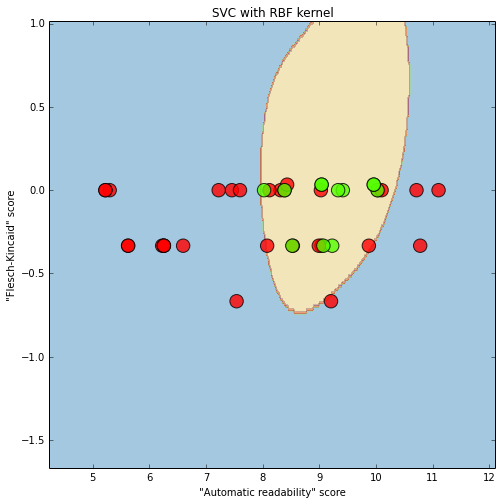

F: 0.64 (+/- 0.34)
Precision: 0.81 (+/- 0.09)
Recall: 0.63 (+/- 0.57)


In [226]:
# -------------- USE THIS ONE ---------------

#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# # import some data to play with
# iris = datasets.load_iris()
# X = iris.data[:, :2]  # we only take the first two features. We could
#                       # avoid this ugly slicing by using a two-dim dataset
# y = iris.target

X = np.array([training.fk_score,training['winning_w']]).T
y = np.array(training.score)

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 15  # SVM regularization param'auto'
clf = svm.SVC(kernel='rbf', gamma=0.6, C=C, class_weight='auto').fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
title = 'SVC with RBF kernel'

Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.prism, alpha = 0.8, s=180)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('"Automatic readability" score')
plt.ylabel('"Flesch-Kincaid" score')
plt.title(title)
fig.set_size_inches(8,8)

plt.show()

from sklearn import cross_validation
scoresF = cross_validation.cross_val_score(clf, X, Y, cv=3,scoring='f1_weighted')
scoresP = cross_validation.cross_val_score(clf, X, Y, cv=3,scoring='precision')
scoresR = cross_validation.cross_val_score(clf, X, Y, cv=3,scoring='recall')


print("F: %0.2f (+/- %0.2f)" % (scoresF.mean(), scoresF.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scoresP.mean(), scoresP.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scoresR.mean(), scoresR.std() * 2))

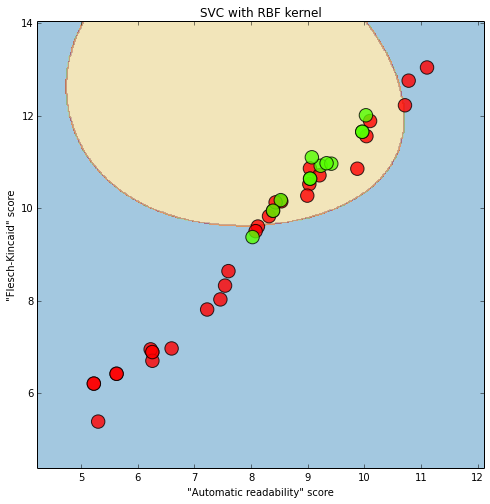

Accuracy: 0.68 (+/- 0.40)


In [231]:
# -------------- FULL SET ---------------

#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

X = np.array([training.fk_score,training.ar_score]).T
y = np.array(training.score)

h = .02  # step size in the mesh

C = 15  # SVM regularization param'auto'
clf = svm.SVC(kernel='rbf', gamma=0.06, C=C, class_weight='auto').fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
title = 'SVC with RBF kernel'

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].


Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.prism, alpha = 0.8, s=180)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('"Automatic readability" score')
plt.ylabel('"Flesch-Kincaid" score')
plt.title(title)
fig.set_size_inches(8,8)

plt.show()

from sklearn import cross_validation
scores = cross_validation.cross_val_score(clf, X, Y, cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

<h1>
<font color = 'red'>
Grid search and cross-validation 
</font>
</h1>

In [237]:
# -------------- FULL SET ---------------

#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from __future__ import print_function

#X = np.array([training.fk_score,training.ar_score,training['winning_w']]).T
X = np.array([training.fk_score,training['winning_w']]).T
y = np.array(training.score)

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.2,0.4,0.5,0.6,0.7,0.8, 1, 1.2, 1.4 ],
                     'C': [1, 5, 10, 15, 20, 30, 40], 'class_weight': ['auto']}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()



# Tuning hyper-parameters for precision

Best parameters set found on development set:

SVC(C=20, cache_size=200, class_weight='auto', coef0=0.0, degree=3, gamma=1.4,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Grid scores on development set:

0.619 (+/-0.245) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.2, 'class_weight': 'auto'}
0.714 (+/-0.200) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.4, 'class_weight': 'auto'}
0.714 (+/-0.200) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.5, 'class_weight': 'auto'}
0.714 (+/-0.200) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.6, 'class_weight': 'auto'}
0.655 (+/-0.187) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.7, 'class_weight': 'auto'}
0.655 (+/-0.187) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.8, 'class_weight': 'auto'}
0.655 (+/-0.187) for {'kernel': 'rbf', 'C': 1, 'gamma': 1, 'class_weight': 'auto'}
0.655 (+/-0.187) for {'kernel': 'rbf', 'C': 1, 'gamma': 1.2, 'class_weight': 'auto'}
0.655 (+/-

In [232]:
range(0.1,1,0.1)

TypeError: range() integer start argument expected, got float.

In [2]:
int(1.0)

1